Use the ChemProp model we created in the previous notebook to generate predictions for the Broad Institute's drug repurposing set. 

Necessary Python imports 

In [1]:
import pandas as pd
from rdkit import Chem
from tqdm.notebook import tqdm

RDKit WARNING: [17:09:48] Enabling RDKit 2019.09.3 jupyter extensions


Get the data from the web

In [2]:
url = "https://s3.amazonaws.com/data.clue.io/repurposing/downloads/repurposing_samples_20180907.txt"
repurposing_df = pd.read_csv(url, comment = "!", sep="\t")

Look at the first few lines of the data table

In [3]:
repurposing_df.head()

,broad_id,pert_iname,qc_incompatible,purity,vendor,catalog_no,vendor_name,expected_mass,smiles,InChIKey,pubchem_cid,deprecated_broad_id
0,BRD-K89787693-001-01-1,"[sar9,met(o2)11]-substance-p",0,NaN,Tocris,1178,2-({5-amino-2-[({1-[6-amino-2-({[1-(2-amino-5-...,"1,392.73",CC(C)C[C@H](NC(=O)CN(C)C(=O)[C@H](Cc1ccccc1)NC...,OUPXSLGGCPUZJJ-SARDKLJWSA-N,163829.0,NaN
1,BRD-K88956297-003-01-9,"1-((Z)-3-Chloroallyl)-1,3,5,7-tetraazaadamanta...",0,94.41,BidePharm,BD51690,"1-((Z)-3-Chloroallyl)-1,3,5,7-tetraazaadamanta...",215.106,Cl\C=C/C[N+]12CN3CN(CN(C3)C1)C2,LDLCEGCJYSDJLX-UPHRSURJSA-N,5846454.0,NaN
2,BRD-A86415025-050-01-0,"1-(1,2-Diphenylethyl)piperidine-(+/-)",0,98.04,Tocris,360,"(?)-1-(1,2-Diphenylethyl)piperidine maleate",265.183,C(C(N1CCCCC1)c1ccccc1)c1ccccc1,JQWJJJYHVHNXJH-UHFFFAOYSA-N,206666.0,NaN
3,BRD-A95802703-001-01-0,1-(2-chloro-5-methylphenoxy)-3-(isopropylamino...,0,92.38,Enamine,Z1672746675,1-(2-chloro-5-methylphenoxy)-3-(isopropylamino...,257.118,CC(C)NCC(O)COc1cc(C)ccc1Cl,NJEIOWSBPCZKTL-UHFFFAOYSA-N,20497006.0,NaN
4,BRD-K96055017-003-02-7,1-acetyl-4-methylpiperazine,0,90.28,Tocris,351,1-Acetyl-4-methylpiperazine hydrochloride,142.111,CN1CCN(CC1)C(C)=O,YSDBJKNOEWSFGA-UHFFFAOYSA-N,550758.0,NaN


How many rows do we have in the table?

In [4]:
repurposing_df.shape

(10147, 12)

How many duplicate molecules are in the table?

In [5]:
len(repurposing_df.smiles.unique())

6245

Looks like we have quite a few duplicates, let's get rid of them

In [6]:
repurposing_df.drop_duplicates('smiles',inplace=True)

Let's make sure that we don't have any null values in the SMILES column.  Note that I wasn't quite so clever the first time I did this, and ChemProp puked on the input. 

In [7]:
repurposing_df.smiles.isnull().value_counts()

False    6244
True        1
Name: smiles, dtype: int64

Oops, we have one null value, let's get rid of it. 

In [8]:
repurposing_df.dropna(axis=0,subset=['smiles'],inplace=True)

Let's check again and make sure we have the right number of rows in the table. 

In [9]:
repurposing_df.shape

(6244, 12)

Write out a file with just the SMILES

In [10]:
repurposing_df[['smiles']].to_csv("broad_repurposing_unqiue.csv",index=False)

Generate the predictions with ChemProp.  Uncomment the line below if you really want to run this. 

In [11]:
#%python ~/software/chemprop/predict.py --test_path broad_repurposing_unqiue.csv --checkpoint_dir chemprop_train --preds_path broad_pred.csv --features_generator rdkit_2d_normalized --no_features_scaling --gpu 0

Read the results from predict.py

In [12]:
result_df = pd.read_csv("broad_pred.csv")

Look at the first few lines

In [13]:
result_df.head()

,smiles,active
0,CC(C)C[C@H](NC(=O)CN(C)C(=O)[C@H](Cc1ccccc1)NC...,0.079717
1,Cl\C=C/C[N+]12CN3CN(CN(C3)C1)C2,0.007592
2,C(C(N1CCCCC1)c1ccccc1)c1ccccc1,0.005925
3,CC(C)NCC(O)COc1cc(C)ccc1Cl,0.013894
4,CN1CCN(CC1)C(C)=O,0.213774


Sort the data based on the "active" column

In [14]:
result_df.sort_values("active",ascending=False,inplace=True)

Add a ranking column

In [15]:
result_df['rank'] = range(0,result_df.shape[0])

In [16]:
result_df.head()

,smiles,active,rank
4168,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(F)c2c(c1F)n(cc(...,0.954957,0
5311,C[C@H]1CN(C[C@@H](C)N1)c1c(F)c(N)c2c(c1F)n(cc(...,0.953678,1
1294,CO[C@]1(NC(=O)C2SC(S2)=C(C(N)=O)C(O)=O)C2SCC(C...,0.948171,2
3330,CCn1cc(C(O)=O)c(=O)c2cc(F)c(N3CCNC(C)C3)c(F)c12,0.947444,3
2387,CN1CCN(CC1)c1c(F)cc2c(c1F)n(CCF)cc(C(O)=O)c2=O,0.945202,4


Now let's see where Halicin ranks based on our ML model.  We will do a substructure search for Halicin.  In order to do this, we will first create a molecule column in our results table.

In [21]:
result_df['mol'] = [Chem.MolFromSmiles(x) for x in tqdm(result_df.smiles)]

Create a SMARTS for Halicin so that we can do the substructure search. 

In [22]:
halicin = Chem.MolFromSmarts("Nc1nnc(Sc2ncc(s2)[N+]([O-])=O)s1")

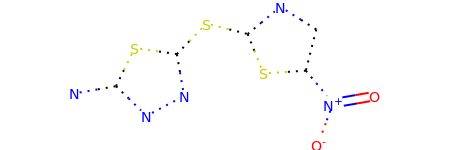

In [23]:
halicin

Do the substructure search

In [24]:
match_list = [x.HasSubstructMatch(halicin) for x in tqdm(result_df.mol)]

Create a new column with the substructure search results

In [25]:
result_df['match'] = match_list

Find the row with Halicin

In [26]:
result_df.query("match")

,smiles,active,rank,mol,match
5380,Nc1nnc(Sc2ncc(s2)[N+]([O-])=O)s1,0.443578,119,<rdkit.Chem.rdchem.Mol object at 0x7f6401db8490>,True


The rank order of Halicin based on our model was 120, while in the paper it was in the top 99, pretty close. 